In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)
dog_df = pd.read_csv(path + '/dogs.csv')

100%|██████████| 215M/215M [00:10<00:00, 20.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2


In [2]:
# libraries for preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
image_path = path + '/' + dog_df['filepaths'].iloc[0]

print(image_path)

/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train/Afghan/001.jpg


In [4]:
# get dataframes of dogs by train/test/validation

train_df = dog_df[dog_df.iloc[:, 2] == "train"].copy()
valid_df = dog_df[dog_df.iloc[:, 2] == "valid"].copy()
test_df = dog_df[dog_df.iloc[:, 2] == "test"].copy()
train_df.head()

# get folder paths of dogs by train/test/validation

train_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train'
valid_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/valid'
test_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/test'

Below is preprocessing + resnet50 model attempt

In [5]:
# considered grayscale but read online somewhere that color is helpful for breed identification
# preprocessing tasks

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    shear_range=0.2,            # Apply shear transformations
    zoom_range=0.2,             # Apply zoom transformations
    horizontal_flip=True       # Flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test/validation

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),    # Resize images
    batch_size=32,             # Adjust as needed based on your memory
    class_mode='categorical'   # Use 'binary' if you have only two classes
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


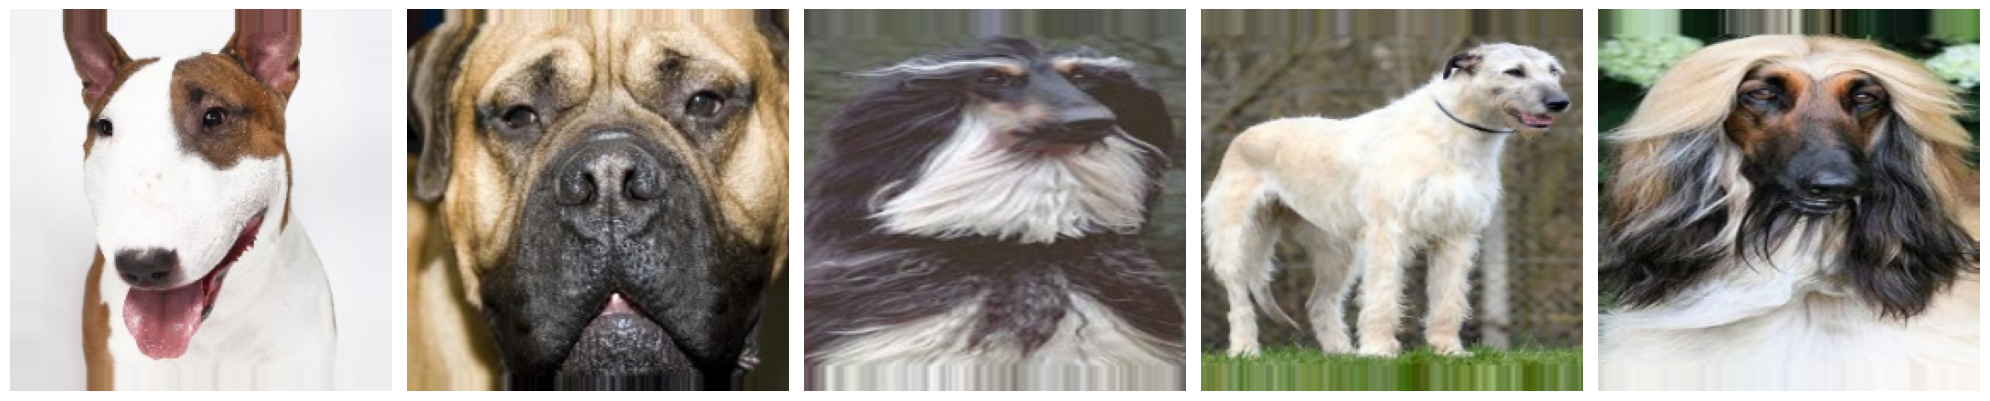

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


sample_training_images, _ = next(train_generator)
plot_images(sample_training_images[:5])

In [7]:
from tensorflow.keras.applications import ResNet50  # Or MobileNetV2, EfficientNetB0, etc.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# 1. Load the pre-trained model (without the top classification layer)
base_model = ResNet50(weights='imagenet', include_top=False)

# 2. Create your own classifier
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Often used with pre-trained models
model.add(Dense(70, activation='softmax'))  # 70 to match our earlier shape

# 3. Freeze the base model layers (optional, but common for initial training)
base_model.trainable = False

# 4. Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Train the model
model.fit(train_generator,epochs=50, validation_data=validation_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 108s 373ms/step - accuracy: 0.0204 - loss: 4.3355 - val_accuracy: 0.0243 - val_loss: 4.2643
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 122s 321ms/step - accuracy: 0.0378 - loss: 4.1729 - val_accuracy: 0.0386 - val_loss: 4.1512
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 323ms/step - accuracy: 0.0453 - loss: 4.1261 - val_accuracy: 0.0386 - val_loss: 4.1107
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 321ms/step - accuracy: 0.0467 - loss: 4.0608 - val_accuracy: 0.0543 - val_loss: 4.0520
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - accuracy: 0.0470 - loss: 4.0512 - val_accuracy: 0.0414 - val_loss: 4.0591
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - accuracy: 0.0571 - loss: 4.0113 - val_accuracy: 0.0729 - val_loss: 4.0257
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 323ms/step - accuracy: 0.0599 - loss: 3.9888 - val_accuracy: 0.0643 - val_loss: 4.0008
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - accuracy: 0.0643 - loss: 3.9719 - v

Below is CNN architecture attempt

In [8]:
!pip install tensorflow.keras.layers
!pip install tensorflow.keras.optimizers
!pip install keras.models
!pip install keras.layers
!pip install keras.utils
!pip install keras.preprocessing.image

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.layers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.layers
ERROR: Could not find a version that satisfies the requirement tensorflow.keras.optimizers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.optimizers
ERROR: Could not find a version that satisfies the requirement keras.layers (from versions: none)
ERROR: No matching distribution found for keras.layers
  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2632 sha256=80621a4065497231ab2a688cd10da7e724c01c6c1248f48e0914c621d87b51ef
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils
ERROR: Could not find a version that satisfies the requirement keras.preprocessing.image (from versions: none)
ERROR: No matching distribution found f

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout , Input , BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale, create directory paths
datagen = ImageDataGenerator(rescale=1./255,)

train_dir = path + '/train/'
test_dir = path + '/test/'
val_dir = path + '/valid/'

In [11]:
train_dataset = datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)

# Load testing data
test_dataset = datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)
val_dataset = datagen.flow_from_directory(
    val_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)
num_classes = 70

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [12]:
input_shape = (224, 224, 3)

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(70, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset , batch_size=32 , verbose=1)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.0286 - loss: 6.8050 - val_accuracy: 0.0200 - val_loss: 4.3064
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.0665 - loss: 4.1790 - val_accuracy: 0.0200 - val_loss: 4.3050
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.0922 - loss: 3.9457 - val_accuracy: 0.0257 - val_loss: 5.3099
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.1191 - loss: 3.7438 - val_accuracy: 0.0686 - val_loss: 4.0521
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.1440 - loss: 3.5996 - val_accuracy: 0.0900 - val_loss: 3.9003
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.1760 - loss: 3.3863 - val_accuracy: 0.1100 - val_loss: 3.7593
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.2141 - loss: 3.1711 - val_accuracy: 0.1286 - val_loss: 3.7072
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.2293 - loss: 3.09